# Training and Validation Script

## Import Library

In [5]:
import os
import re
import zipfile
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import gdown
import zipfile

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Import Dataset

In [ ]:
# download zip file dataset from https://drive.google.com/file/d/1XeG9uoCu6Cokx2hlYVbHyy2OUONmsK-u/view?usp=share_link

url = "https://drive.google.com/file/d/1XeG9uoCu6Cokx2hlYVbHyy2OUONmsK-u/view?usp=share_link"
output = "dataset.zip"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1XeG9uoCu6Cokx2hlYVbHyy2OUONmsK-u
To: /content/dataset.zip
100%|██████████| 8.64M/8.64M [00:00<00:00, 21.0MB/s]


'dataset.zip'

In [6]:
filenames = os.listdir()

for file in filenames:
  dataset = re.search(r'^dataset.*\.zip$', file)

  if dataset:
    zip_path = f'./{file}'
    zip_ref = zipfile.ZipFile(zip_path, 'r')
    zip_ref.extractall(path='./')
    zip_ref.close()

## ETL (Extract Transform Load)

In [8]:
# Create dataset builder

# Extract (Specifying path)
base_dir = './dataset/'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Extract (Generating dataset from directory)
BATCH_SIZE = 32
# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (160, 160)
VAL_SPLIT = 0.2

def build_dataset(train_val, dir, subset=None):
  if train_val:
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        validation_split=VAL_SPLIT,
        subset=subset,
        # label_mode='binary',
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        seed=123)
  else:
    return tf.keras.preprocessing.image_dataset_from_directory(
        dir,
        labels='inferred',
        # label_mode='binary',
        class_names=['caries', 'no-caries'],
        batch_size=BATCH_SIZE,)


# Execute dataset building
train_ds = build_dataset(True, train_dir, "training")
val_ds = build_dataset(True, train_dir, "validation")
test_ds = build_dataset(False, test_dir)

class_names = train_ds.class_names
print(class_names)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.
Found 56 files belonging to 2 classes.
['caries', 'no-caries']


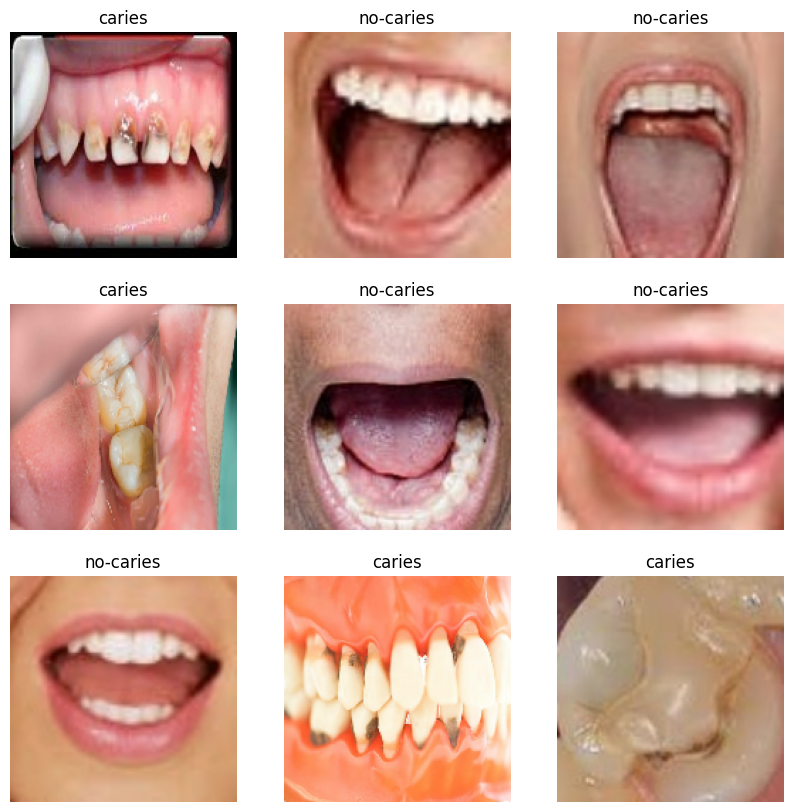

In [9]:
# Visualize dataset image

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    labels = labels.numpy().astype("uint8")
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

### Preprocessing Images using keras preprocessing layers

In [10]:
# Transform (Preprocessing data)

# optimize data I/O
AUTOTUNE = tf.data.AUTOTUNE

IMG_SIZE = 160

image = next(iter(train_ds))

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomTranslation(0, 0.2),
  layers.RandomTranslation(0.2, 0),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  # layers.RandomBrightness(0.1)
])

def prepare(ds, resize=False, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  if resize:
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Load (Apply preprocessing and load data)

train_ds = prepare(train_ds, resize=False, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Building Model using Transfer Learning

In [12]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 8s 1us/step


In [15]:
# Model Architecture

output = 2 #@param {type:"integer"}
activation = "linear" #@param ["linear", "sigmoid", "softmax"]

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(output, activation=activation)
prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
from_logits = True #@param {type:"boolean"}

model.compile(
  optimizer = optimizers.Adam(learning_rate=0.001), 
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=from_logits),
  metrics = ['accuracy']
)

## Model Training with freezed layers

In [ ]:
# Define callback functions

import datetime

def get_callbacks():
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
  ]

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir,
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
NUM_EPOCHS = 25

history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = NUM_EPOCHS,
  verbose = 2,
  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                         experiment_name="Training Model at " + datetime.datetime.now().strftime("%H%M")), 
             get_callbacks()])

Saving TensorBoard log files to: tensorflow_hub/Training Model at 0231/20230609-023127
Epoch 1/25
13/13 - 9s - loss: 0.7812 - accuracy: 0.5625 - val_loss: 0.6330 - val_accuracy: 0.6700 - 9s/epoch - 725ms/step
Epoch 2/25
13/13 - 3s - loss: 0.4367 - accuracy: 0.8100 - val_loss: 0.3312 - val_accuracy: 0.8500 - 3s/epoch - 221ms/step
Epoch 3/25
13/13 - 4s - loss: 0.3283 - accuracy: 0.8600 - val_loss: 0.2263 - val_accuracy: 0.9000 - 4s/epoch - 338ms/step
Epoch 4/25
13/13 - 3s - loss: 0.2986 - accuracy: 0.8800 - val_loss: 0.2157 - val_accuracy: 0.8900 - 3s/epoch - 217ms/step
Epoch 5/25
13/13 - 3s - loss: 0.2534 - accuracy: 0.8975 - val_loss: 0.1444 - val_accuracy: 0.9600 - 3s/epoch - 233ms/step
Epoch 6/25
13/13 - 3s - loss: 0.2288 - accuracy: 0.9000 - val_loss: 0.1535 - val_accuracy: 0.9500 - 3s/epoch - 251ms/step
Epoch 7/25
13/13 - 3s - loss: 0.2421 - accuracy: 0.9100 - val_loss: 0.1577 - val_accuracy: 0.9300 - 3s/epoch - 218ms/step
Epoch 8/25
13/13 - 3s - loss: 0.2317 - accuracy: 0.9025 - v

## Fine Tuning Model (Please RUN after training with freezed layers)
Prone to overfit

In [ ]:
feature_extractor.trainable = True

In [ ]:
model.compile(
  optimizer = optimizers.Adam(), 
  loss = 'binary_crossentropy', 
  metrics = ['accuracy']
)

In [ ]:
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = 50,
  verbose = 2,
  callbacks=get_callbacks())

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model Evaluation

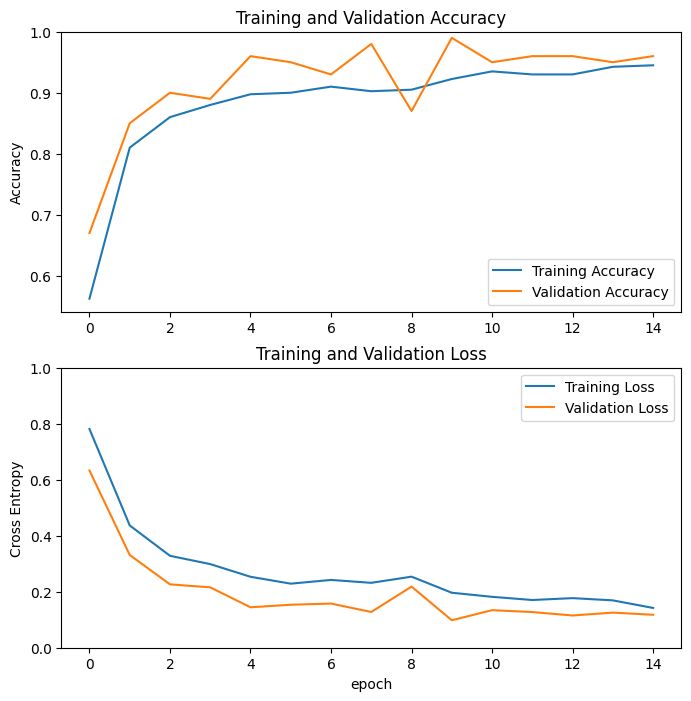

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Test model with data from test_ds

sample = test_ds.take(1)

evaluation = model.evaluate(sample, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 155ms/step - loss: 0.2563 - accuracy: 0.8750

loss: 0.2563
accuracy: 0.8750


## TensorBoard compare

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "Confidentz Model Log" \
  --description "Comparing Confidentz models with limited amount of training images" \
  --one_shot

2023-06-07 04:31:13.242229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/qvmuOr3GQ2e79fBiQ64RFA/

[2023-06-07T04:31:14] Started scanning logdir.
[2023-06-07T04:31:15] Total uploaded: 2340 scalars, 0 tensors, 0 binary objects
[2023-06-07T04:31:15] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/qvmuOr3GQ2e79fBiQ64RFA/


In [ ]:
# Check out experiments (uncomment to see)
# !tensorboard dev list 

In [ ]:
# Delete an experiment
# !tensorboard dev delete --experiment_id zaoOrUv9SX6bW3JJV5bLNw

2023-06-04 05:05:47.942860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment zaoOrUv9SX6bW3JJV5bLNw.


## Predict New Data

In [ ]:
# change filename to file you want to predict

filename = 'gigisehat3.jpg'
img = load_img(filename, target_size=(160, 160))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
images = np.vstack([img_array])
print(img_array.shape)

prediction = model.predict(images, batch_size=10)
print(prediction[0])

score = tf.nn.softmax(prediction[0])
print(
    "{} detected with a {:.2f} percent confidence.\n"
    .format(class_names[np.argmax(score)], 100 * np.max(score))+
    "{} detected with a {:.2f} percent confidence."
    .format(class_names[np.argmin(score)], 100 * np.min(score))
)

(1, 160, 160, 3)
1/1 [==============================] - 0s 36ms/step
[-1.5561045   0.20249787]
no-caries detected with a 85.30 percent confidence.
caries detected with a 14.70 percent confidence.


In [ ]:
# Save model to HDF5 format or .h5 file format

# Save the entire model to a HDF5 file.
model.save('confidentz_model.h5')

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
reloaded_model = tf.keras.models.load_model("confidentz_model.h5")

# Show the model architecture
reloaded_model.summary()

In [ ]:
# Predict with reloaded model

# change filename to file you want to predict
filename = 'caries.jpg'
img = load_img(filename, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# stack dimension vertically
images = np.vstack([x])
classes = reloaded_model.predict(images, batch_size=10)
print(classes)

1/1 [==============================] - 0s 41ms/step
[[0.02425903]]
